# Getting X-ray mass absorption/attenuation coefficient data from the NIST's website by web scraping 

In this ipybn file, it's explain how to implement a simple code that helps us to obtain all the mass absorption 
$\frac{\mu_{\textnormal{abs}}}{\rho}$/attenuation $\frac{\mu}{\rho} $ coefficient  of elements data and mass absorption coefficient of certain compounds and mixtures data, often used in X-ray physics.

Data scraped are available in the NIST website: https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients. 

## 1. Introduction

The motivation of this work rises from the necessity to calculate a quantity that doesn't involve just one value of the mentioned coefficients but involves values over a certain range of energy. For example, in dosimetry of polyenergetic X-rays beams it's habitual to obtain the dose absorbed in water, $D_{\textnormal{w}}$, from a measure of air kerma, $K_{\textnormal{air}}$, by the following equation [1]: 

$$ D_{\textnormal{w}}= K_{\textnormal{air}}\cdot\frac{\displaystyle{\int_0^{E_{\textnormal{max}}} \left(\frac{\mu_{\textnormal{abs}}(E)}{\rho}\right)_{\textnormal{w}}E\Phi_E^{\textnormal{air}}(E)dE}}{\displaystyle{\int_0^{E_{\textnormal{max}}} \left(\frac{\mu_{\textnormal{abs}}(E)}{\rho}\right)_{\textnormal{air}}E\Phi_E^{\textnormal{air}}(E)dE}}$$

Where the $\frac{\mu_{\textnormal{abs}}}{\rho}$ curves of air and water over the interval $[0,E_{\textnormal{max}}]$ are needed. In this case, the coefficients of both compounds are in the NIST database, so we can just copy directly from the page:

![mu_scraping1.png](mu_scraping1.png)

Figure 1: *Screenshot from the NIST site* (**Source: NIST**)

As we can see in the picture above, there is an 18 K besides the energy column corresponding to the absorption edge of the compound. This represents a little problem because when the data is pasted, the values of corresponding row will move one place to the right. It easily solves just by erasing the 18 k manually. But, what happens when we have a compound like photographic emulsion that has 15 absorption edges? Or when the compound of interest is not in database and we need to obtain his coefficients from the  coefficients  of the elements that compose it, each one with own absorption edges? The task becomes a little bit tedious. 

With this on mind, let's start with the code. We import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import requests

## 2. Coefficients of elements

First we try to get the data of only one element, let's say the Xenon (Z=54). 

We use the URL of the xenon page:

In [2]:
# Save the URL:
URL_BASE = 'https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z54.html'

# Make the page request:
request_obtained = requests.get(URL_BASE)

# Substract the html code as text:
html_obtained = request_obtained.text

# Convert the code to a beautiful soup object:
soup = BeautifulSoup(html_obtained, 'html.parser')
type(soup)

bs4.BeautifulSoup

To know if it worked, we get the title of the page:

In [3]:
soup.title

<title>NIST: X-Ray Mass Attenuation Coefficients - Xenon</title>

Now, we inspect the page to found the pattern followed by HTML tags containing data in order to generate a suitable code:   

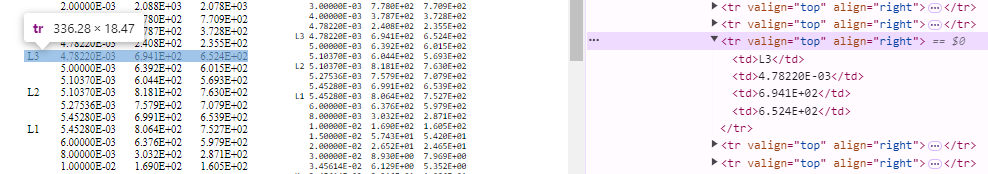

Figure 2: *Screenshot from the NIST site* (**Source: NIST**)

By a fast inspection it can be note that only rows of the table with HTML format, corresponds to a 'tr' tags with attributes *valign* and *align* equals to *top* and *right* respectively, so we used that:

In [4]:
# Obtain an iterable with all tags <tr valing ='top' align='right'> 
table = soup.findAll("tr", {'valign':'top', 'align':'right'})

# Some elements of the iterable:
table[0], table[3], table[-1]  

(<tr align="right" valign="top">
 <td rowspan="3"> </td>
 <td>1.00000E-03</td>
 <td>9.413E+03</td>
 <td>9.393E+03</td>
 </tr>,
 <tr align="right" valign="top">
 <td>M1</td>
 <td>1.14900E-03</td>
 <td>7.338E+03</td>
 <td>7.321E+03</td>
 </tr>,
 <tr align="right" valign="top">
 <td>2.00000E+01</td>
 <td>4.815E-02</td>
 <td>3.139E-02</td>
 </tr>)

Comparing with data on the page, we note that get what we want. More over, we note that in each 'tr' tag, the values of interest correspond with the last 3 'td' tags containing in it. Thus, we obtain that 3 'td' tags of each row:

In [5]:
for i in range(len(table)):
    table[i] = table[i].findAll('td')[-3:]
    for j in range(3):
        table[i][j] = table[i][j].text

# the first 5 elements
table[0:5]

[['1.00000E-03', '9.413E+03', '9.393E+03'],
 ['1.07191E-03', '8.151E+03', '8.132E+03'],
 ['1.14900E-03', '7.035E+03', '7.019E+03'],
 ['1.14900E-03', '7.338E+03', '7.321E+03'],
 ['1.50000E-03', '4.085E+03', '4.073E+03']]

In this way, we obtained all the data of interest for Xenon:

In [6]:
df = pd.DataFrame(table).rename(columns={0:'Energy', 1:'Attenuation', 2:'Absorption'})
df.head(5)

,Energy,Attenuation,Absorption
0,1.00000E-03,9.413E+03,9.393E+03
1,1.07191E-03,8.151E+03,8.132E+03
2,1.14900E-03,7.035E+03,7.019E+03
3,1.14900E-03,7.338E+03,7.321E+03
4,1.50000E-03,4.085E+03,4.073E+03


To reproduce the NIST website graph, firts we note:

In [7]:
df.dtypes

Energy         object
Attenuation    object
Absorption     object
dtype: object

In [8]:
# Convert data to float format
df = df.astype({'Energy':float, 'Absorption':float, 'Attenuation':float})
df.dtypes

Energy         float64
Attenuation    float64
Absorption     float64
dtype: object

Then we graph:

In [9]:
# style graphic function
def graph_style (tit, labx, laby):
    """
    Function for settings of graphs

    tit: Graph title\n
    labx: x axis name\n
    laby: y axis name\n
    """
    plt.figure()
    plt.style.use('seaborn-v0_8')
    plt.title(tit, fontsize=20)
    plt.xlabel(labx, fontsize=17)
    plt.ylabel(laby, fontsize=27)
    

y_label='$\\frac{\mu_{en}}{\\rho}$ , $\\frac{\mu_{en}}{\\rho}$  $\left[\\frac{cm^2}{g} \\right]$'


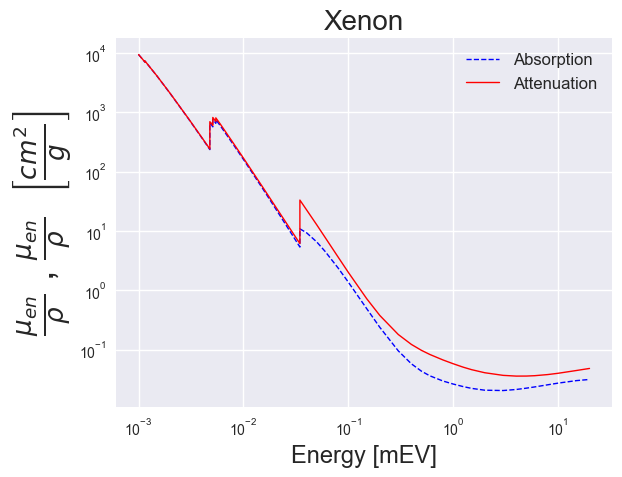

In [10]:
# build the graph
graph_style(tit='Xenon', labx='Energy [mEV]', laby=y_label)
plt.errorbar(df.Energy, df.Absorption, label='Absorption', color='b', ls='--', lw=1)
plt.errorbar(df.Energy, df.Attenuation, label='Attenuation', color='r', ls='-', lw=1)
plt.loglog()
plt.legend( fontsize= 12)
plt.show()

Once we know the procedure works, generalize the code to get the data of whatever elements we want.

First we note that, for elements, the URL: 

<center>'https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z<b>54</b>.html'</center>

changes with the elements only in the atomic number reference (after z, before .html, at the end of the URL), 54 in this case. Thus, if we need data about a list of elements, we just iterate the code written before over that list:

In [11]:
def obtain_elements_coefficients(elements_list):
    """
    Function to obtain the mass absorption/attenuation coefficients of elements specified by the user. Returns a csv file with data for each element.

    element_list:  A list whose elements are the atomic numbers of the elements of interest (integers from 1 to 92)
    """
    for element in elements_list:

        request_obtained = requests.get(f'https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z{str(element).zfill(2)}.html')
        html_obtained = request_obtained.text
        soup = BeautifulSoup(html_obtained, 'html.parser')
        data = soup.findAll("tr", {'valign':'top', 'align':'right'})

        for i in range(len(data)):
            data[i] = data[i].findAll('td')[-3:]
            for j in range(3):
                data[i][j] = data[i][j].text
        df = pd.DataFrame(data, dtype = float).rename(columns = {0:'Energy', 1:'Attenuation', 2:'Absorption'})
        df.to_csv(f'z{element}_element_data.csv', index = False)


# 3. Example with the element coefficients. 

Suppose that we want to obtain the mass absorption/attenuation coefficient curves from the air, dry (near sea level). 

According to NIST [2] One unit of air, dry (near sea level) is a mixture compounded by 0.000124 units of C (z=6), 0.755268 of N (z=7), 0.231781 of O (z=8) and 0.012827 of Ar (z=18). With these proportions, we can obtain the mass absorption coefficients of the mixture as follows [3]: 

$$\left(\frac{\mu_{\textnormal{abs}}}{\rho}\right)_{\textnormal{air}}= (0.000124)\cdot\left(\frac{\mu_{\textnormal{abs}}}{\rho}\right)_{\textnormal{C}}+(0.755268)\cdot\left(\frac{\mu_{\textnormal{abs}}}{\rho}\right)_{\textnormal{N}}+(0.231781)\cdot\left(\frac{\mu_{\textnormal{abs}}}{\rho}\right)_{\textnormal{O}}+(0.012827)\cdot\left(\frac{\mu_{\textnormal{abs}}}{\rho}\right)_{\textnormal{Ar}}$$

The same occurs with $\frac{\mu}{\rho}$. On that basis we first obtain data:

In [12]:
obtain_elements_coefficients([6,7,8,18])

In [13]:
# Import data from csv files
C = pd.read_csv('z6_element_data.csv')
N = pd.read_csv('z7_element_data.csv')
O = pd.read_csv('z8_element_data.csv')
Ar= pd.read_csv('z18_element_data.csv')

Before sum the coefficient values, first we noticed that energy range are not the same with each element. For example, in the image below, we can see air having 2 energy values more than H:

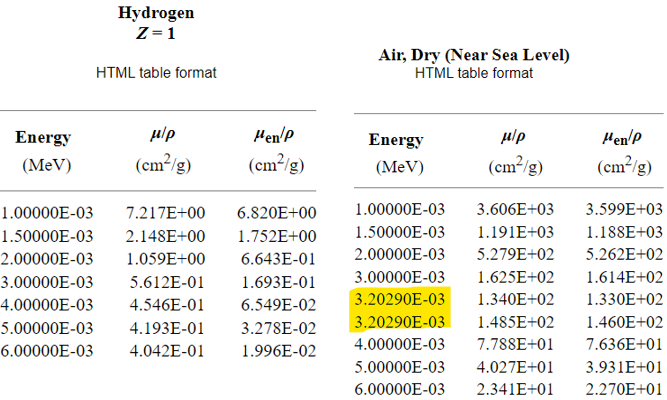

Figure 3: *Screenshot from the NIST site* (**Source: NIST**)

If we see how many energy values have the studied elements:

In [14]:
len(O),len(Ar),len(C),len(N)

(36, 38, 36, 36)

We note the Ar has 2 more energy values than the other elements. Even if the elements has the same amount of values, these may don't coincide with each other. For that reason, we have to obtain the common values of energy:

In [15]:
Energy_values = set(C.Energy).intersection(set(N.Energy), set(O.Energy), set(Ar.Energy))

In [16]:
# difference betwen original values and common values:
print(set(Ar.Energy).difference(Energy_values),
set(N.Energy).difference(Energy_values),
set(O.Energy).difference(Energy_values),
set(C.Energy).difference(Energy_values))  

{0.0032029} set() set() set()


Where is clear that Ar energy range only differs from the other elements in 2 points, both with the same value of 0.0032029. So we drop these points:

In [17]:
Ar = Ar.drop(Ar[Ar['Energy']==0.0032029].index).reset_index().drop('index', axis=1)
len(Ar)

36

Now we can calculate and graph the coefficients correctly:

In [18]:
mu_abs = 0.000124*C.Absorption + 0.755268*N.Absorption + 0.231781*O.Absorption + 0.012827*Ar.Absorption
mu = 0.000124*C.Attenuation + 0.755268*N.Attenuation + 0.231781*O.Attenuation + 0.012827*Ar.Attenuation

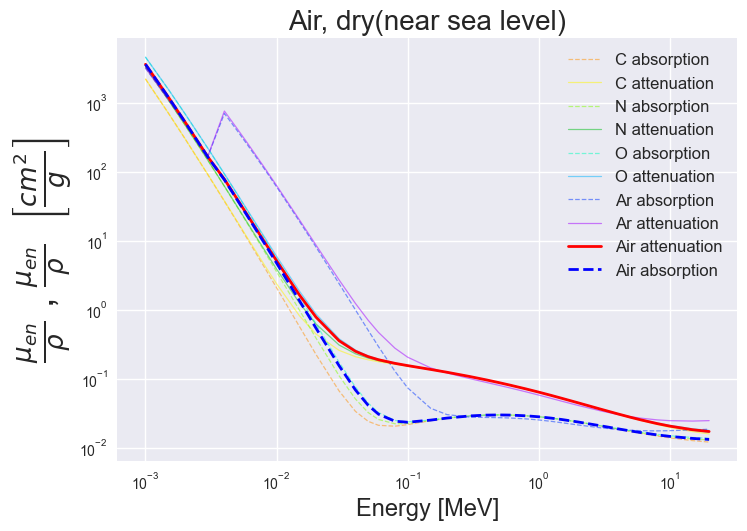

In [19]:
graph_style(tit= 'Air, dry(near sea level)', labx='Energy [MeV]', laby=y_label)
plt.errorbar(Ar.Energy, C.Absorption, fmt='--',color='#ff8f00', lw=0.9, label='C absorption',alpha=0.5)
plt.errorbar(Ar.Energy, C.Attenuation, fmt='-',color='#fff600', lw=0.9, label='C attenuation',alpha=0.5)
plt.errorbar(Ar.Energy, N.Absorption, fmt='--',color='#80ff00', lw=0.9, label='N absorption', alpha=0.5)
plt.errorbar(Ar.Energy, N.Attenuation, fmt='-',color='#00be15', lw=0.9, label='N attenuation', alpha=0.5)
plt.errorbar(Ar.Energy, O.Absorption, fmt='--',color='#00ffbd', lw=0.9, label='O absorption', alpha=0.5)
plt.errorbar(Ar.Energy, O.Attenuation, fmt='-',color='#00b3ff', lw=0.9, label='O attenuation', alpha=0.5)
plt.errorbar(Ar.Energy, Ar.Absorption, fmt='--',color='#0034ff', lw=0.9, label='Ar absorption', alpha=0.5)
plt.errorbar(Ar.Energy, Ar.Attenuation, fmt='-',color='#a100ff', lw=0.9, label='Ar attenuation', alpha=0.5)
plt.errorbar(Ar.Energy, mu, fmt='-',color='r', lw=2, label='Air attenuation')
plt.errorbar(Ar.Energy, mu_abs,fmt='--', color='b', lw=2, label='Air absorption')
plt.loglog()
plt.legend(fontsize=12)
plt.show()

By compare with the graph of figure 1 of the beginning, we can say that results are consistent at least qualitatively. Falling to mention that we were able to get a graph containing more than one element information.

## 4. Coefficients of compounds and mixtures

In addition to elements data, the NIST has mass absorption/attenuation coefficient data of certain compounds and mixtures, including the dry (near sea level) air: 

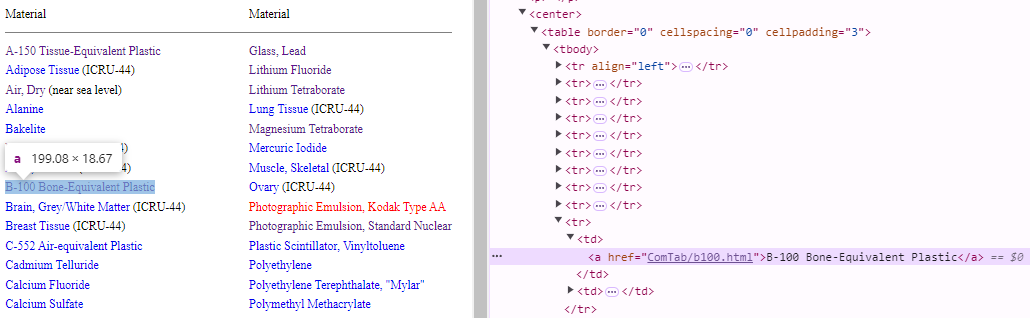

Figure 4: *Screenshot from the NIST site* (**Source: NIST**)

In this case, the URL to access data only changes in the key of the corresponding component/mixture. For example, to access data of *B-100 bone-quivalent plastic* we have a URL with the key *b100* (figure 4) so first we have to obtain the keys of all components and mixtures. For this we note that in the page all links of compounds and mixtures are 'a' tags containing the name of the compound/mixture, with the href class following the pattern  **ComTab/*key*.html**: 


In [20]:
# Figure 4 site's URL:
URL_BASE_COMPOUNDS = 'https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html'

# Scraping:
request_compounds = requests.get(URL_BASE_COMPOUNDS)
html_compounds = request_compounds.text
soup = BeautifulSoup(html_compounds, 'html.parser')

In [21]:
# get 'a' tags 
a_tags_list = soup.findAll('a')

# dictionary with the complete names of compounds as keys
compounds_dict = {}

for tag in a_tags_list:
    href = tag['href']
    if href.startswith('ComTab') == True:
        compounds_dict[tag.text] = href.replace('ComTab/', '').replace('.html', '')

compounds_dict     

{'A-150 Tissue-Equivalent Plastic': 'a150',
 'Glass, Lead': 'glass',
 'Adipose Tissue': 'adipose',
 'Lithium Fluoride': 'lithiumflu',
 'Air, Dry': 'air',
 'Lithium Tetraborate': 'lithium',
 'Alanine': 'alanine',
 'Lung Tissue': 'lung',
 'Bakelite': 'bakelite',
 'Magnesium Tetraborate': 'magnesium',
 'Blood, Whole': 'blood',
 'Mercuric Iodide': 'mercuric',
 'Bone, Cortical': 'bone',
 'Muscle, Skeletal': 'muscle',
 'B-100 Bone-Equivalent Plastic': 'b100',
 'Ovary': 'ovary',
 'Brain, Grey/White Matter': 'brain',
 'Photographic Emulsion, Kodak Type AA': 'kodak',
 'Breast Tissue': 'breast',
 'Photographic Emulsion, Standard Nuclear': 'photoemul',
 'C-552 Air-equivalent Plastic': 'c552',
 'Plastic Scintillator, Vinyltoluene': 'vinyl',
 'Cadmium Telluride': 'telluride',
 'Polyethylene': 'polyethylene',
 'Calcium Fluoride': 'fluoride',
 'Polyethylene Terephthalate, "Mylar"': 'mylar',
 'Calcium Sulfate': 'calcium',
 'Polymethyl Methacrylate': 'pmma',
 '15 mmol L-1 Ceric Ammonium Sulfate Solutio

Now we are able to implement the scraping data of compound and mixtures to our original function:

In [22]:
def obtain_coefficients(item_list):
    """
    Function to obtain the mass absorption/attenuation coefficients of elements, compounds or mixtures specified by the user. Returns a csv file with data for each item.

    item_list:  A list whose elements can be the atomic numbers of the elements (integers from 1 to 92) or the names of compounds/mixtures (Available in the NIST website) of interest.    
    """

    # Item validations:

    exceptions_counter = 0
    for item in item_list:

        # Z range validation
        if type(item) == int:
            if item < 0 or 92 < item:
                print(f'{item} is out of valid range of Z')
                exceptions_counter +=  1
        # Names validation
        elif type(item) == str:
            if compounds_dict.get(item) == None:
                print(f'{item} is not a valid compound/mixture name')
                exceptions_counter +=  1
        # Format validation        
        else:
            exceptions_counter +=  1
            print(f'{item} has not integer or string format')

    print(f'\n{exceptions_counter} exceptions found')

    if exceptions_counter == 0:
        for item in item_list:
            if type(item) == int:
                request_obtained = requests.get(f'https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z{str(item).zfill(2)}.html')
            else:
                request_obtained = requests.get(f'https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/{compounds_dict[item]}.html')
            html_obtained = request_obtained.text
            soup = BeautifulSoup(html_obtained, 'html.parser')
            data = soup.findAll("tr", {'valign':'top', 'align':'right'})

            for i in range(len(data)):
                data[i] = data[i].findAll('td')[-3:]
                for j in range(3):
                    data[i][j] = data[i][j].text
            df = pd.DataFrame(data, dtype = float).rename(columns = {0:'Energy', 1:'Attenuation', 2:'Absorption'})
            df.to_csv(f'{item}_data.csv', index = False)
        print('function executed correctly')
    
    else:
        print('please try again')


In [23]:
# Test with an incorrect input: 
obtain_coefficients([1,2,'perro',{},98,'Ferrous Sulfate, Standard Fricke'])

perro is not a valid compound/mixture name
{} has not integer or string format
98 is out of valid range of Z

3 exceptions found
please try again


In [24]:
# Test with a correct input:
obtain_coefficients([1,'Air, Dry'])  


0 exceptions found
function executed correctly


Taking advantage of the fact that we have got 2 mass absorption/attenuation coefficients of dry air datasets, one calculated from the coefficients of each element compounding it and one obtained directly from NIST database, we compare both datasets:

In [26]:
# Import data achieved from NIST: 
Air = pd.read_csv('Air, Dry_data.csv')

In [27]:
# Compare Air data with Ar data 
len(Air), len(Ar), set(Air.Energy).difference(set(Ar.Energy))

(38, 36, {0.0032029})

We note that Air has the same set of energies that Ar so in order to compare the energy values correctly, we repeat the set intersection trick applied with Ar some cells above:

In [28]:
Air = Air.drop(Air[Air['Energy']==0.0032029].index).reset_index().drop('index', axis=1)

We make a graph to visual comparison:

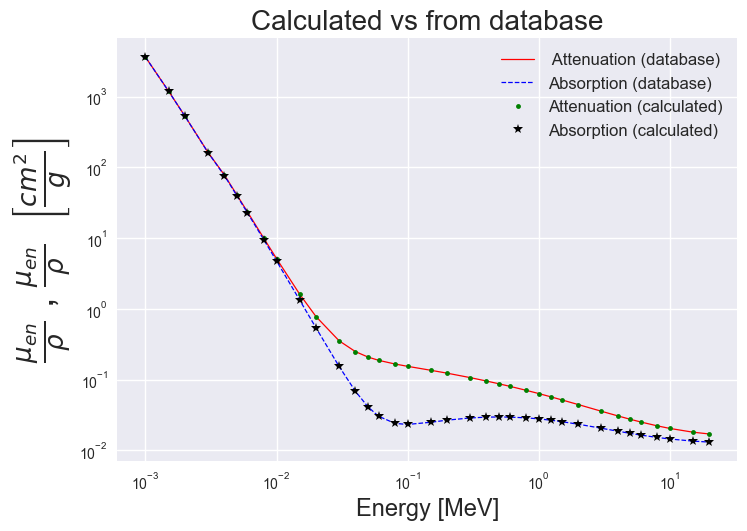

In [29]:
graph_style(tit='Calculated vs from database', labx='Energy [MeV]', laby=y_label)
plt.errorbar(Air.Energy, mu, fmt='-',color='r', lw=0.9, label=' Attenuation (database)')
plt.errorbar(Air.Energy, mu_abs,fmt='--', color='b', lw=0.9, label='Absorption (database)')
plt.errorbar(Air.Energy, Air.Attenuation, fmt='.',color='g', lw=0.9, label='Attenuation (calculated)')
plt.errorbar(Air.Energy, Air.Absorption,fmt='*', color='black', lw=0.9, label='Absorption (calculated)')
plt.loglog()
plt.legend(fontsize=12)
plt.show()


Where calculations are consistent with the NIST data. 

To be able to say something quantitative, we can calculate the percent relative difference between two datasets:

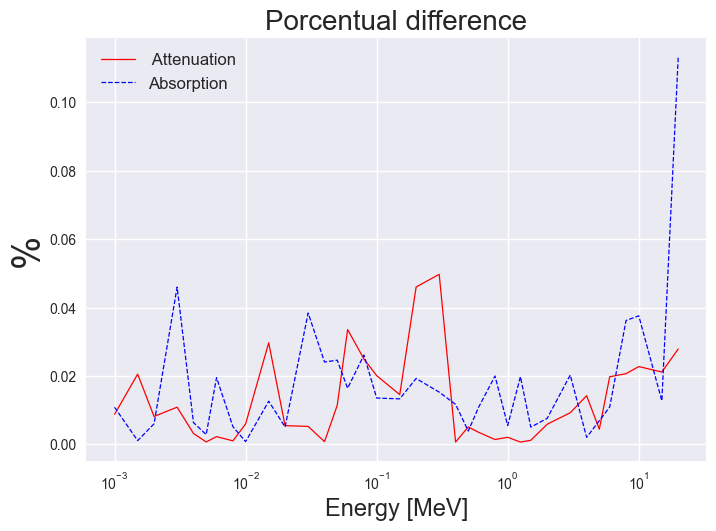

In [30]:
Y = abs((Air.Attenuation - mu))/mu*100
Y_abs = abs((Air.Absorption - mu_abs))/mu_abs*100

# Build the graph:
graph_style(tit='Porcentual difference', labx='Energy [MeV]', laby='%')
plt.errorbar(Air.Energy, Y, fmt='-',color='r', lw=0.9, label=' Attenuation')
plt.errorbar(Air.Energy, Y_abs,fmt='--', color='b', lw=0.9, label='Absorption')
plt.xscale('log')
plt.legend(fontsize=12)
plt.show()

Setting aside the only case of the absorption at the biggest energy, we can say that the differences between calculated dataset and obtained from database, is less than 0.05%. Even in the worst case of absorption at the biggest energy, the difference remains less of 0.12% (that is, a difference of 0.012 with values in the order of 10).

In conclusion, if we want to calculate the mass absorption coefficient<sup>1</sup> of some compound/mixture don't contained in the NIST database, one option is to investigate his chemical composition and the proportion in which each element is present in the substance and implement until now explained.

*1. We don't mention the mass attenuation coefficient calculation because the NIST actually has a tool [4] that calculate it for you, but only with the attenuation.*

# 5. References

[1] C.-M. Ma, C. W. Coffey, L. A. DeWerd, C. Liu, R. Nath, S. M. Seltzer, and J. P. Seuntjens, “Aapm protocol for 40–300 kv x-ray beam dosimetry in radiotherapy and radiobiology,” Medical Physics, vol. 28, no. 6, pp. 868–893, 2001.

[2] NIST, "X-ray mass attenuation coefficients - Table 2". https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html

[3] NIST, “Xcom: Photon cross sections database. Introduction”, https://physics.nist.gov/PhysRefData/Xcom/Text/intro.html

[4] NIST, “Xcom: Element/Compound/Mixture", https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html

